In [742]:
import numpy as np
import matplotlib.pyplot as plt

# Q-LEARNING SECTION
### functions for environment, rho calculations, 
### epsilon-greedy policy, soft max expectation calculation

In [743]:
max = 12.0
step = 0.05

states = np.arange(0, max, step)
actions = np.arange(0, max, step)

size = round(max / step)

T = 4
Q = np.full((T, size, size), 30.00)
# epsilon = 0.01
om_q = 0.55
om_mu = 0.85
gamma = 0.2
rho = 0.95
softmax_param = 15
C = 3
mu = np.ones(T)

# idk about this factor (gamma in the pseudocode), a value was not mentioned in their description
discount = 0.95

# given white noise process with specific supports and probabilities
supp_W = [0.9, 1.3]
pmf_W = [0.75, 0.25]

# calculate expectation of white noise process 
exp_W_gamma = 0
for i in range(len(supp_W)):
    exp_W_gamma += np.pow(supp_W[i], gamma) * pmf_W[i]

# calculate rho * expectation [W ^ gamma]
pEWgamma = rho * exp_W_gamma

# white noise with two outcomes with probabilities established above
def W ():
    return np.random.choice(supp_W, p = pmf_W)

# given state/action (by index) and mean field investment
# return through G(mu, W()) * a (amount invested)
# the new state (rounded)
# and using formula for utility calculate reward
def env (state, action, mu):
    consump = states[state] - actions[action]
    wealth = actions[action] * W() * C / (pEWgamma * (1 + (C - 1) * np.pow(mu, 3)))
    newState = round(wealth / step)
    utility = np.pow(consump, gamma) / gamma
    return { 'x': newState, 'u': utility }

# rho calculator, given we are on the kth episode and
# have visited the specific state/action/time pair count_txa times
def rhosCalc(count_txa, k):
    rhoQ = 1 / np.pow(1 + count_txa, om_q)
    rhoMu = 1 / np.pow(2 + k, om_mu)
    return { 'q': rhoQ, 'mu': rhoMu }
    
# using the formula, calcula te softmax probabilities
# and choose an action given the pmf probabilities
def softMinAct (Q_x, x_idx):
    max_x_idx = np.argmax(Q_x)
    max_x = states[max_x_idx]
    dif = []
    for a in range (x_idx + 1):
        dif.append(max_x - Q_x[a])

    sum = 0
    weights = np.zeros(x_idx + 1)
    for a in range (x_idx + 1):
        weights[a] = np.exp(-softmax_param * dif[a])
        sum += weights[a]

    weights = weights / sum
    return np.random.choice(list(range(x_idx + 1)), p = weights)
    

num_episodes = 5000000
jump = round(num_episodes / 100)

mu_k = []
for t in range(T):
    mu_k.append([])

# initialize count for finding rho_Q (learning rate)
count_txa = np.zeros([T, len(states), len(actions)])

# Learning loop
for k in range(num_episodes):

    # Sample initial state 
    x_idx = np.random.choice(list(range(0, round(1 / step) + 1)))
    
    # Episode loop over time periods
    for t in range(T):
        
        # Ensure valid state
        if x_idx >= len(states) or x_idx < 0:
            print("error")
            break
            
        # Current Q values at t
        Q_xt = Q[t, x_idx, :]
        
        # Select action
        a_idx = softMinAct(Q_xt, x_idx)
        
        # Skip if action exceeds state 
        if a_idx > x_idx:
            print("act > stat")
            a_idx = np.copy(x_idx)  #Invest everything instead of breaking
        
        #call to environment
        result = env(x_idx, a_idx, mu[t])
        next_x_idx = result['x']
        reward = result['u']
        
        # Check next state is within the state space
        next_x_idx = np.min([np.max([next_x_idx, 0]), len(states) - 1])
        
        # Calculate target
        if t < T - 1:
            if next_x_idx > 0:
                max_next_Q = np.max(Q[t + 1, next_x_idx, :next_x_idx + 1])
            else:
                max_next_Q = Q[t + 1, 0, 0]
            td_target = reward + max_next_Q
        else:
            #end state
            td_target = reward + rho * np.pow(states[next_x_idx], gamma) / gamma

        # target for mean field
        a_target = actions[a_idx]
        
        # Update count for learning rate
        count_txa[t, x_idx, a_idx] += 1
        
        # Calculate learning rates
        rhos = rhosCalc(count_txa[t, x_idx, a_idx], k)
        rho_Q = rhos['q']
        rho_Mu = rhos['mu']
        
        # Q-learning update
        Q[t, x_idx, a_idx] = Q[t, x_idx, a_idx] + rho_Q * (td_target - Q[t, x_idx, a_idx])
        
        # Mean field distribution update
        mu[t] = mu[t] + rho_Mu * (a_target - mu[t])

        # Move to next state
        x_idx = next_x_idx

        if (k) % jump == 0:
            mu_k[t].append(mu[t])

for t in range(T):
    mu_k[t].append(mu[t])

## Theoretical Mean Field Action and Optimal Policy Calculation

In [744]:
from scipy.optimize import fsolve
m0 = 0.5


def Phi(z):
    exp_G_gamma = 0
    for i in range (len(supp_W)):
        exp_G_gamma += pmf_W[i] * np.pow(supp_W[i] * C / (pEWgamma * (1 + (C - 1) * np.pow(z, 3))), gamma)
    return rho * exp_G_gamma

def phi(z):
    return np.power(Phi(z), 1.0 / (gamma - 1))

def Psi(z):
    exp_G = 0
    for i in range (len(supp_W)):
        exp_G += pmf_W[i] * supp_W[i] * C / (pEWgamma * (1 + (C - 1) * np.pow(z, 3)))
    return exp_G

def fixed_point_equations(z_vec):
    z_vec
    D = np.zeros(T + 1)
    D[T] = 1.0
    try:
        for t in range (T, 0, -1):
            D[t - 1] = phi(z_vec[t - 1]) * D[t] / (1 + phi(z_vec[t - 1]) * D[t])
    except:
        return np.full(T, 1e10)
    
    Psi_prod = [m0]
    phi_prod_seq_sum = [1]
    for k in range(1, T):
        Psi_prod.append(Psi_prod[-1] * Psi(z_vec[k - 1]))
        prod = 1.0
        for i in range(T - k, T):
            prod = prod * phi(z_vec[i])
        phi_prod_seq_sum.append(phi_prod_seq_sum[-1] + prod)
    
    prod = 1.0
    for i in range(0, T):
            prod = prod * phi(z_vec[i])
    phi_prod_seq_sum.append(phi_prod_seq_sum[-1] + prod)
    
    Lambda = []
    for k in range(T):
        Lambda.append(Psi_prod[k] * phi_prod_seq_sum[T - k - 1] / phi_prod_seq_sum[T])
    
    residuals = [z_vec[k] - Lambda[k] for k in range(T)]
    return residuals

print("Solving theoretical solution...")
z_initial = np.full(T, m0)
z_theoretical, _, ier, _ = fsolve(fixed_point_equations, z_initial, full_output=True)

# Calculate D values
D_theoretical = np.zeros(T + 1)
D_theoretical[T] = 1.0
for t in range(T - 1, -1, -1):
    D_theoretical[t] = phi(z_theoretical[t]) * D_theoretical[t + 1] / (1 + phi(z_theoretical[t]) * D_theoretical[t + 1])

# Calculate theoretical policy coefficients
coefficients_theory = []
for t in range(T + 1):
    if t <= T - 1:
        coef = 1 / (1 + phi(z_theoretical[t]) * D_theoretical[t + 1])
    else:
        coef = 0
    coefficients_theory.append(coef)


def value_function (t, x):
    return np.pow(D_theoretical[t], gamma - 1) * np.pow(states[x], gamma) / gamma

print("\nTheoretical Policy Coefficients α̂_t(x) = c_t * x:")
for t in range(T):
    print(f"    z_{t} = {z_theoretical[t]:.6f}    c_{t} = {coefficients_theory[t]:.6f}")


Solving theoretical solution...

Theoretical Policy Coefficients α̂_t(x) = c_t * x:
    z_0 = 0.417897    c_0 = 0.835794
    z_1 = 0.880691    c_1 = 0.763103
    z_2 = 0.810105    c_2 = 0.687734
    z_3 = 0.655289    c_3 = 0.527366


In [745]:
# table of the count of times the program reaches a scenario (time step, state, action)
'''
for t in range (T):
    print("           t = %1d" % (t))
    for x in range (size):
        print("x = %5.2f: " % (states[x]), end = '')
        for a in range (x + 1):
            if count_txa[t, x, a] == 0:
                print("      ", end = '')
            else:
                print("%5d " % (count_txa[t, x, a]), end = '')
        print("")
    print("")
'''
print("usable if helpful")

usable if helpful


# Visualizations

(0.0, 7.0)

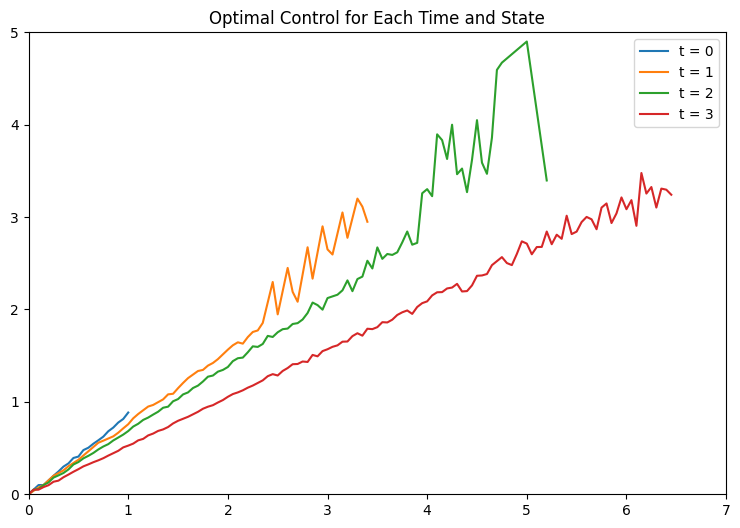

In [753]:
# utilizing the soft max distribution
# calculate the expectation of an action choice
def softMaxMean (Q_tx, x_idx):
    sum = 0
    expectation = 0
    weights = np.zeros(x_idx + 1)
    for a in range(x_idx + 1):
        weights[a] = np.exp(softmax_param * Q_tx[a])
        sum += weights[a]
        expectation += weights[a] * actions[a]
    return expectation / sum

# iterate through each time step and state to calculate optimal policy from soft max expectation
# only calculate for policy for time/state pairs that were visited at least "qualify" times
qualify = 500
optimIND = []
optim = []
for t in range (T):
    optim.append([])
    optimIND.append([])
    for x in range (size):
        if (np.sum(count_txa[t, x]) > qualify):
            optim[t].append(softMaxMean(Q[t, x, :], x))
            optimIND[t].append(states[x])

%matplotlib inline

plt.figure(figsize = (9, 6))
plt.plot(optimIND[0], optim[0])
plt.plot(optimIND[1], optim[1])
plt.plot(optimIND[2], optim[2])
plt.plot(optimIND[3], optim[3])
plt.legend(["t = 0", "t = 1", "t = 2", "t = 3"])
plt.title("Optimal Control for Each Time and State")
plt.ylim([0, 5.0])
plt.xlim([0, 7.0])

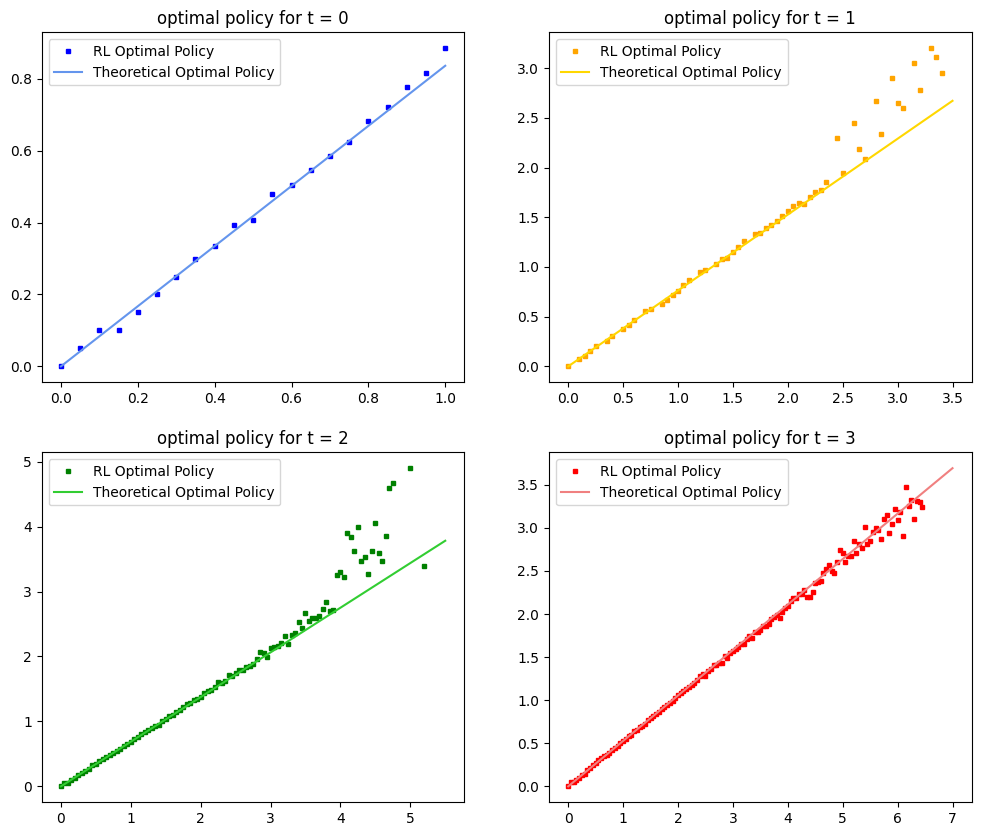

In [754]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(optimIND[0], optim[0], color='blue', marker = 's', markersize = 3, linewidth = 0)
axs[0, 0].plot([0, 1], [0, coefficients_theory[0]], color='cornflowerblue')
axs[0, 0].set_title('optimal policy for t = 0')
axs[0, 0].legend(["RL Optimal Policy", "Theoretical Optimal Policy"])

axs[0, 1].plot(optimIND[1], optim[1], color='orange', marker = 's', markersize = 3, linewidth = 0)
axs[0, 1].plot([0, 3.5], [0, 3.5 * coefficients_theory[1]], color='gold')
axs[0, 1].set_title('optimal policy for t = 1')
axs[0, 1].legend(["RL Optimal Policy", "Theoretical Optimal Policy"])

axs[1, 0].plot(optimIND[2], optim[2], color='green', marker = 's', markersize = 3, linewidth = 0)
axs[1, 0].plot([0, 5.5], [0, 5.5 * coefficients_theory[2]], color='limegreen')
axs[1, 0].set_title('optimal policy for t = 2')
axs[1, 0].legend(["RL Optimal Policy", "Theoretical Optimal Policy"])

axs[1, 1].plot(optimIND[3], optim[3], color='red', marker = 's', markersize = 3, linewidth = 0)
axs[1, 1].plot([0, 7], [0, 7 * coefficients_theory[3]], color='lightcoral')
axs[1, 1].set_title('optimal policy for t = 3')
axs[1, 1].legend(["RL Optimal Policy", "Theoretical Optimal Policy"])

(0.4, 1.02)

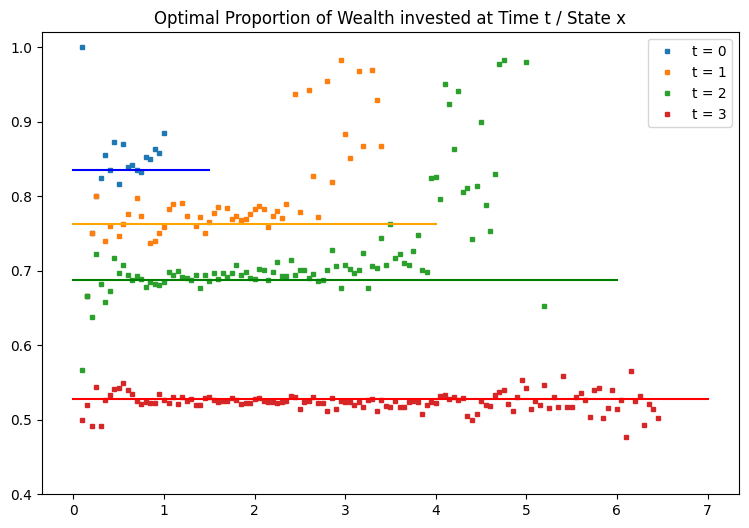

In [755]:
# calculating ratio of state to optimal action
# should be a horizontal line function
prop = []
for t in range(T):
    prop.append([])
    for i in range(2, len(optimIND[t])):
        prop[t].append(optim[t][i] / optimIND[t][i])

%matplotlib inline

plt.figure(figsize = (9, 6))
plt.plot(optimIND[0][2:], prop[0], marker = 's', markersize = 3, linewidth = 0)
plt.plot(optimIND[1][2:], prop[1], marker = 's', markersize = 3, linewidth = 0)
plt.plot(optimIND[2][2:], prop[2], marker = 's', markersize = 3, linewidth = 0)
plt.plot(optimIND[3][2:], prop[3], marker = 's', markersize = 3, linewidth = 0)
plt.plot([0, 1.5], [coefficients_theory[0], coefficients_theory[0]], color = 'blue')
plt.plot([0, 4], [coefficients_theory[1], coefficients_theory[1]], color = 'orange')
plt.plot([0, 6], [coefficients_theory[2], coefficients_theory[2]], color = 'green')
plt.plot([0, 7], [coefficients_theory[3], coefficients_theory[3]], color = 'red')
plt.legend(["t = 0", "t = 1", "t = 2", "t = 3"])
plt.title("Optimal Proportion of Wealth invested at Time t / State x")
plt.ylim([0.4, 1.02])

Text(0.5, 1.0, 'Mean Field Action throughout Q-learning episodes')

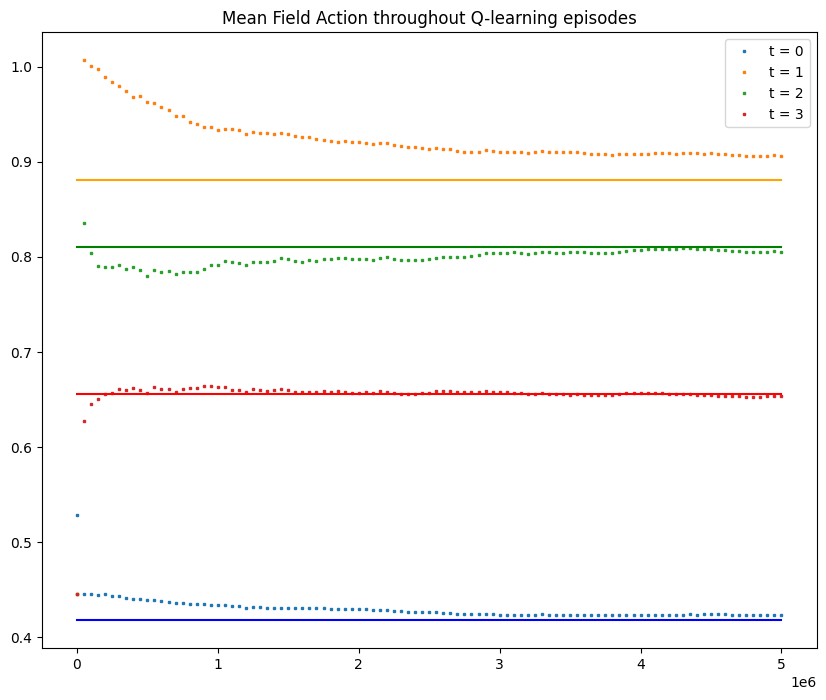

In [756]:
# trend of mean field wealth invested through episodes
plt.figure(figsize = (10, 8))
plt.plot(list(range(0, num_episodes + jump, jump)), mu_k[0], marker = 's', markersize = 2, linestyle = 'none')
plt.plot(list(range(0, num_episodes + jump, jump)), mu_k[1], marker = 's', markersize = 2, linestyle = 'none')
plt.plot(list(range(0, num_episodes + jump, jump)), mu_k[2], marker = 's', markersize = 2, linestyle = 'none')
plt.plot(list(range(0, num_episodes + jump, jump)), mu_k[3], marker = 's', markersize = 2, linestyle = 'none')
plt.plot([0, num_episodes], [z_theoretical[0], z_theoretical[0]], color = 'blue')
plt.plot([0, num_episodes], [z_theoretical[1], z_theoretical[1]], color = 'orange')
plt.plot([0, num_episodes], [z_theoretical[2], z_theoretical[2]], color = 'green')
plt.plot([0, num_episodes], [z_theoretical[3], z_theoretical[3]], color = 'red')
plt.legend(["t = 0", "t = 1", "t = 2", "t = 3"])
plt.title("Mean Field Action throughout Q-learning episodes")